# Intro

In [2]:
import pandas as pd
import numpy as np
import random
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score
from sklearn.metrics import fbeta_score, make_scorer
from sklearn.model_selection import train_test_split
from imblearn.pipeline import make_pipeline, Pipeline
from imblearn.under_sampling import EditedNearestNeighbours # resampling
from imblearn.combine import SMOTEENN # resampling
from lightgbm import LGBMClassifier
import optuna


# Set metric
def f2_measure(y_true, y_pred):
    return fbeta_score(y_true, y_pred, beta=2)
f2_score = make_scorer(f2_measure) 

# Set seeds
seeds = 1234
def set_seeds(seed=seeds):
    """Set seeds for reproducibility."""
    np.random.seed(seed)
    random.seed(seed)
set_seeds()

# Set k-fold cross-validation
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=seeds)

# Load data
df = pd.read_pickle(r"train_enc.pkl")
test = pd.read_pickle(r"test_enc.pkl")

# Separate labels and target
X, y =  df.drop(columns="left", axis = 1), df["left"]
X_test, y_test =  test.drop(columns="left", axis = 1), test["left"]

In [3]:
# Get variable names
bi_vars = [col for col in X.columns if X[col].nunique() == 2]
num_vars = [col for col in X.columns if (X[col].dtype in ["int8", "float32"]) & (col not in bi_vars)]
cat_vars = [col for col in X.columns if (col not in num_vars) & (col not in bi_vars)]

# Preprocessing
preprocess = ColumnTransformer(
    transformers=[
        ("scaler", MinMaxScaler(), num_vars),
        ("ohe", OneHotEncoder(), cat_vars)
    ], remainder = "passthrough"
)

# Resampling 
smoteen = SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority'), random_state=seeds)

In [ ]:
        "objective": "binary",
        "metric": "auc",
        "verbosity": -1,
        "boosting_type": "gbdt",
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "min_child_samples": trial.suggest_int("min_child_samples", 5, 100),

In [3]:
def objective(trial):
    params = {
            'n_estimators':trial.suggest_int("n_estimators", 1000, 10000),
            'learning_rate' : trial.suggest_uniform('learning_rate', 0.001, 1),
            'subsample': trial.suggest_uniform('subsample', 0.1, 1),
            'colsample_bytree':trial.suggest_uniform('colsample_bytree', 0.1, 1),
            'max_depth': trial.suggest_categorical('max_depth', [1,3,5,7,9,11,13,15,17,20]),
            'min_child_weight': trial.suggest_int('min_child_weight', 1, 300),
            'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-5, 10.0),
            'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-5, 10.0),
                    "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "num_leaves": trial.suggest_int("num_leaves", 2, 256),
    }
    clf = LGBMClassifier(random_state=seeds,**params)
    model = make_pipeline(preprocess, smoteen, clf)
    # Evaluate model
    scores = cross_val_score(model, X, y, scoring=f2_score, cv=cv, n_jobs=-1).mean()
    return scores

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=150)
best_params = study.best_trial.params
print('Number of finished trials:', len(study.trials))
print('Best trial:', best_params)

[I 2022-02-19 14:29:59,218] A new study created in memory with name: no-name-15cafc6b-bb4c-4ed2-899a-b0487df7d6df
[I 2022-02-19 14:30:10,547] Trial 0 finished with value: 0.8053544325797664 and parameters: {'n_estimators': 2583, 'learning_rate': 0.07977498779003575, 'subsample': 0.5289339175079663, 'colsample_bytree': 0.5915782813759934, 'max_depth': 20, 'min_child_weight': 93, 'reg_lambda': 1.600534709959207e-05, 'reg_alpha': 0.00029582691007067334, 'lambda_l1': 1.1763767266706047e-05, 'lambda_l2': 0.31540746902593436, 'num_leaves': 49}. Best is trial 0 with value: 0.8053544325797664.
[I 2022-02-19 14:30:17,778] Trial 1 finished with value: 0.7721911568860038 and parameters: {'n_estimators': 1492, 'learning_rate': 0.15234817001373335, 'subsample': 0.8462380275471618, 'colsample_bytree': 0.6171227964443432, 'max_depth': 9, 'min_child_weight': 250, 'reg_lambda': 0.2965512973537026, 'reg_alpha': 8.953418274166719, 'lambda_l1': 0.0165456324958619, 'lambda_l2': 0.005708855136731613, 'num_l

Number of finished trials: 150
Best trial: {'n_estimators': 1211, 'learning_rate': 0.0655617061483102, 'subsample': 0.8424673374069434, 'colsample_bytree': 0.7456098558853268, 'max_depth': 9, 'min_child_weight': 28, 'reg_lambda': 1.748029886598557e-05, 'reg_alpha': 0.011816434352783945, 'lambda_l1': 3.342275961260333, 'lambda_l2': 9.28445946270099, 'num_leaves': 167}


# Results

I'm still using test set to evaluate metrics like a confusion matrix, which is totally wrong. I should use training to evaluate all theses metrics with cross_val_predict().

In [4]:
from sklearn.model_selection import cross_val_predict
best_params= {'n_estimators': 1211, 'learning_rate': 0.0655617061483102, 'subsample': 0.8424673374069434, 'colsample_bytree': 0.7456098558853268, 'max_depth': 9, 'min_child_weight': 28, 'reg_lambda': 1.748029886598557e-05, 'reg_alpha': 0.011816434352783945, 'lambda_l1': 3.342275961260333, 'lambda_l2': 9.28445946270099, 'num_leaves': 167}


lgbm_clf = LGBMClassifier(random_state=seeds,**best_params)

final_pipeline = make_pipeline(preprocess, smoteen, lgbm_clf)

y_train_pred = cross_val_predict(final_pipeline, X, y,cv=cv)

[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current

In [5]:
def evaluate_train(model):
    # Fit the model on training set
    model.fit(X, y)
    # Obtain the predictions
    preds = cross_val_predict(final_pipeline, X, y, cv=cv)
    # Predict probabilities
    #probs = model.predict_proba(X_test)
    # Print the F2-score, classification report and confusion matrix
    print("F2-score: {} " .format(round(fbeta_score(y, preds, beta=2), 3)))
    print(classification_report(y, preds))
    print(confusion_matrix(y, preds))

evaluate_train(final_pipeline)

[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current

In [6]:
y_scores = cross_val_predict(final_pipeline, X, y, cv=cv,method="predict_proba")

[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current

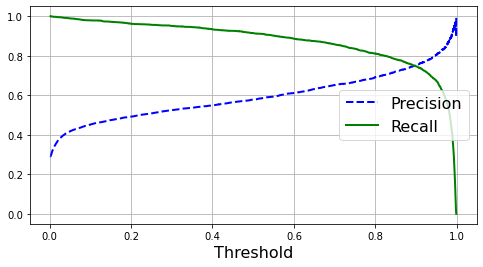

In [7]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt
precisions, recalls, thresholds = precision_recall_curve(y, y_scores[:,1])

recall_90_precision = precisions[np.argmax(recalls >= 0.90)]
threshold_90_precision = thresholds[np.argmax(recalls >= 0.90)]

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.legend(loc="center right", fontsize=16) # Not shown in the book
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown

plt.figure(figsize=(8, 4))                                             
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.show()

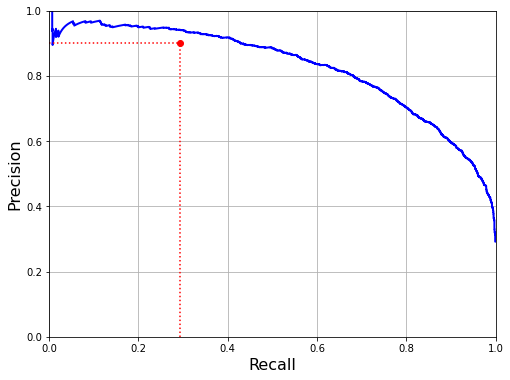

In [12]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
plt.plot([recall_90_precision, recall_90_precision], [0., 0.9], "r:")
plt.plot([0.0, recall_90_precision], [0.9, 0.9], "r:")
plt.plot([recall_90_precision], [0.9], "ro")
plt.show()

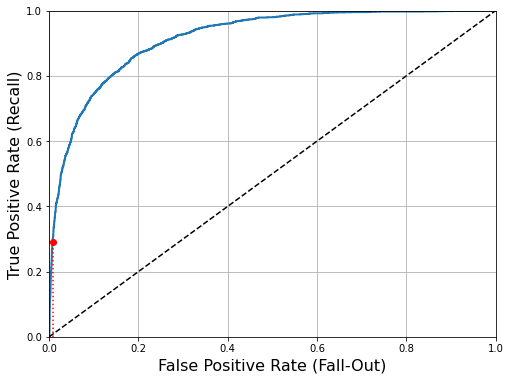

In [14]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y, y_scores[:,1])

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown in the book
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown                                  # Not shown
plt.show()

In [15]:
# Reassign loan status based on the threshold
df_val = pd.DataFrame(y_scores)

df_val['pred_1'] = df_val[1].apply(lambda x: 1 if x > recall_90_precision else 0)

# Print the classification report
print("F2-score: {} " .format(round(fbeta_score(y, y_train_pred, beta=2), 3)))
print(classification_report(y, df_val['pred_1']))
print(confusion_matrix(y, df_val[['pred_1']]))


F2-score: 0.82 
              precision    recall  f1-score   support

           0       0.97      0.64      0.77      5405
           1       0.52      0.95      0.68      2227

    accuracy                           0.73      7632
   macro avg       0.75      0.80      0.72      7632
weighted avg       0.84      0.73      0.74      7632

[[3472 1933]
 [ 104 2123]]


## Final evaluation

[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099
F2-score: 0.834 
              precision    recall  f1-score   support

           0       0.97      0.72      0.82      1351
           1       0.58      0.94      0.71       557

    accuracy                           0.78      1908
   macro avg       0.77      0.83      0.77      1908
weighted avg       0.85      0.78      0.79      1908



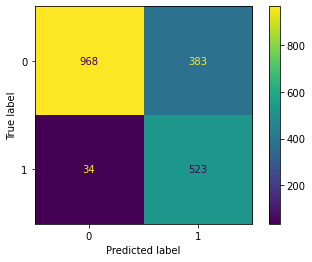

In [18]:
def evaluate(model):
    # Fit the model on training set
    model.fit(X, y)
    # Obtain the predictions
    preds = model.predict(X_test)
    # Predict probabilities
    #probs = model.predict_proba(X_test)
    # Print the F2-score, classification report and confusion matrix
    print("F2-score: {} " .format(round(fbeta_score(y_test, preds, beta=2), 3)))
    print(classification_report(y_test, preds))
    ConfusionMatrixDisplay.from_estimator(final_pipeline, X_test, y_test)

evaluate(final_pipeline)

THe confusion matrix was used to evaluate the classification predictions. The Matrix showed a model recall of X% for class 1.

In [19]:
def get_results(model):
    # Fit the model on training set
    model.fit(X, y)
    # Obtain the predictions
    preds = model.predict(X_test)
    # Predict probabilities
    probs = model.predict_proba(X_test)
    return preds, probs

preds, probs = get_results(final_pipeline)

[LightGBM] [Warning] lambda_l1 is set=3.342275961260333, reg_alpha=0.011816434352783945 will be ignored. Current value: lambda_l1=3.342275961260333
[LightGBM] [Warning] lambda_l2 is set=9.28445946270099, reg_lambda=1.748029886598557e-05 will be ignored. Current value: lambda_l2=9.28445946270099


In [20]:
# Create pred column on test set
df_test = test.copy()
df_test["pred_left"] = preds
df_test["prob_left"] = probs[:,1]
df_test["pred_mod"] = df_test["prob_left"].apply(lambda x: 1 if x > recall_90_precision else 0)

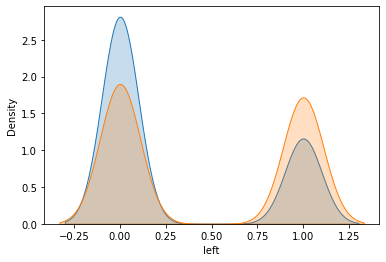

In [30]:
import seaborn as sns
sns.kdeplot(df_test["left"], shade=True, label="A")
sns.kdeplot(df_test["pred_left"], shade=True, label="B")
plt.show()

In [33]:
# Probability that prediction is better
(diff > 0).mean()

0.20073375262054508

In [35]:
loss = diff[diff < 0]
expected_loss = loss.mean()
expected_loss

-1.0

              precision    recall  f1-score   support

           0       0.98      0.63      0.77      1351
           1       0.52      0.96      0.67       557

    accuracy                           0.73      1908
   macro avg       0.75      0.80      0.72      1908
weighted avg       0.84      0.73      0.74      1908

[[851 500]
 [ 21 536]]


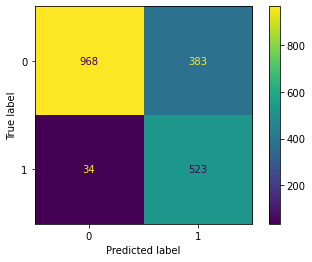

In [21]:
from sklearn.metrics import ConfusionMatrixDisplay
print(classification_report(y_test, df_test["pred_mod"]))
print(confusion_matrix(y_test, df_test["pred_mod"]))
ConfusionMatrixDisplay.from_estimator(final_pipeline, X_test, y_test)

How our model is detecting those who churn?

Our model detect churned employees 95% of the time.

26 employees where predicted non-churned but actually churned.

Next. Use pickle to dump the model for re-use later.

{'whiskers': [<matplotlib.lines.Line2D at 0x2cf8018ee50>,
 'caps': [<matplotlib.lines.Line2D at 0x2cf801a0430>,
 'boxes': [<matplotlib.lines.Line2D at 0x2cf8018eb80>,
 'medians': [<matplotlib.lines.Line2D at 0x2cf801a09d0>,
 'fliers': [<matplotlib.lines.Line2D at 0x2cf801a0ca0>,
 'means': []}

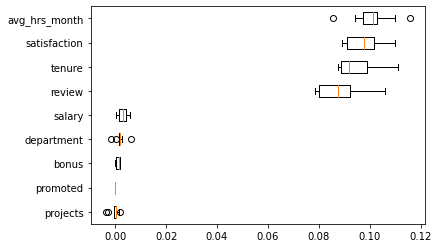

In [8]:
from sklearn.inspection import permutation_importance
result = permutation_importance(final_pipeline, X_test, y_test, n_repeats=10,
                                random_state=seeds, n_jobs=2)

sorted_idx = result.importances_mean.argsort()
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X.columns[sorted_idx])

In [10]:
result.importances_mean

array([ 0.00188679,  0.        ,  0.08784067, -0.00010482,  0.00303983,
        0.09460168,  0.09722222,  0.00120545,  0.10104822])